# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Feature extraction
from sklearn.feature_selection import VarianceThreshold

from boruta import BorutaPy
from sklearn.inspection import permutation_importance

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Classification models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data_path = "../../data/"

# Data

In [3]:
df_radiomics = pd.read_excel(data_path + 'quantitative_radiomic_features.xls')
df_radiomics['Lesion Name'] = df_radiomics['Lesion Name'].str.replace(r'-1\.les|-S2-1\.les', '', regex=True)

target_class = pd.read_csv(data_path + 'target_class.csv')
target_class.rename(columns={'CLID': 'Lesion Name'}, inplace=True)

In [4]:
df = pd.merge(df_radiomics, target_class, on='Lesion Name', how='inner')
df = df.drop(columns=df.columns[0])
df

,Maximum enhancement (K1),Time to peak (K2),Uptake rate (K3),Washout rate (K4),Curve shape index (K5),E1 (K6),Signal Enhancement Ratio (SER) (K7),Maximum enhancement-variance (E1),Enhancement-Variance Time to Peak (E2),Enhancement-variance Increasing Rate (E3),...,Margin Sharpness (M1),Variance of Margin Sharpness (M2),Variance of Radial Gradient Histogram (vRGH) (M3),Size/Lesion volume (S1),Effective Diameter (S2),Surface Area (S3),Surface Area to Volume ratio (G3),Volume of most enhancing voxels (S4),Maximum Diameter (S5),Pam50.Call
0,1.602573,145.433,0.011019,0.000809,-0.099998,1.550204,1.111109,0.125963,60.000,0.002099,...,0.188643,0.000143,0.014881,3139.6540,18.16747,2897.7040,0.922937,22.15705,27.60382,LumA
1,4.072152,144.752,0.028132,0.001510,-0.007311,3.973258,1.007365,4.054312,229.504,0.017666,...,0.266607,0.000371,0.011217,1122.5800,12.89455,953.7904,0.849641,111.70860,21.31066,LumA
2,1.303264,168.383,0.007740,0.000667,-0.146959,1.273733,1.172277,0.534411,60.000,0.008907,...,0.269997,0.000323,0.005211,8211.5000,25.03079,6920.3380,0.842762,236.23630,41.33787,LumA
3,0.758630,60.000,0.012644,0.000479,-0.150482,0.758630,1.177138,0.037956,298.418,0.000127,...,0.179068,0.000407,0.020553,569.5309,10.28426,585.4972,1.028034,122.69640,11.39449,LumA
4,3.353556,60.000,0.055893,0.000920,-0.080066,3.353556,1.087034,2.330160,60.000,0.038836,...,0.314553,0.000409,0.004073,19709.4700,33.51394,18107.5700,0.918724,245.36130,68.62797,LumB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.277688,60.000,0.021295,0.000611,-0.149392,1.277688,1.175629,0.271695,60.000,0.004528,...,0.235470,0.002210,0.006303,6066.8380,22.62844,5934.5540,0.978195,94.23584,51.20215,LumA
72,1.495674,60.000,0.024928,0.000093,-0.017541,1.495674,1.017854,0.123041,60.000,0.002051,...,0.218222,0.000760,0.010302,1419.0820,13.94236,1621.7530,1.142819,88.69263,22.50068,LumA
73,2.182750,60.000,0.036379,0.001081,-0.125678,2.182750,1.143744,0.225339,313.733,0.000718,...,0.195256,0.000169,0.007831,5328.3800,21.67033,3618.5270,0.679105,89.18701,30.87951,Basal
74,1.354828,192.786,0.007028,0.000067,0.043301,1.290058,0.958496,0.108778,60.000,0.001813,...,0.211480,0.000169,0.014482,2196.5620,16.12804,2166.4220,0.986278,36.73828,23.13763,LumA


# Feature extraction

## Functions

In [5]:
def apply_variance_threshold(df, target_col, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    df_features = selector.fit_transform(df.drop(columns=[target_col]))
    selected_columns = df.drop(columns=[target_col]).columns[selector.get_support()]
    
    return df_features, selected_columns

In [6]:
def apply_boruta(df_features, target, selected_columns, model_name="RandomForest", n_estimators=100, random_state=42):
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=n_estimators, random_state=random_state),
        "GradientBoosting": GradientBoostingClassifier(n_estimators=n_estimators, random_state=random_state),
        "ExtraTrees": ExtraTreesClassifier(n_estimators=n_estimators, random_state=random_state),
    }
    
    if model_name not in models:
        raise ValueError(
            f"Model '{model_name}' is not supported by Boruta. "
        )
    
    model = models[model_name]
    
    boruta_selector = BorutaPy(model, n_estimators='auto', random_state=random_state)
    boruta_selector.fit(df_features, df[target])
    selected_features = selected_columns[boruta_selector.support_]
    
    return selected_features

In [7]:
def cluster_and_select_representative_features(correlation_matrix, num_clusters):
    distance_matrix = 1 - np.abs(correlation_matrix)
    linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='ward')
    
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    cluster_df = pd.DataFrame({
        "Feature": correlation_matrix.columns,
        "Cluster": clusters
    })
    
    representative_features = []
    for cluster_id in cluster_df["Cluster"].unique():
        cluster_features = cluster_df.loc[cluster_df["Cluster"] == cluster_id, "Feature"].values
        cluster_corr = correlation_matrix.loc[cluster_features, cluster_features].mean(axis=1)
        representative = cluster_corr.idxmax()
        representative_features.append(representative)
    
    return representative_features

## Procedure

In [8]:
df_features, selected_columns_after_variance = apply_variance_threshold(df, "Pam50.Call")

In [9]:
print(f"Number of features retained after applying variance threshold: {len(selected_columns_after_variance)}")
print(f"Selected features: {selected_columns_after_variance}")

Number of features retained after applying variance threshold: 24
Selected features: Index(['Maximum enhancement (K1)', 'Time to peak (K2)',
       'Curve shape index (K5)', 'E1 (K6)',
       'Signal Enhancement Ratio (SER) (K7)',
       'Maximum enhancement-variance (E1)',
       'Enhancement-Variance Time to Peak (E2)',
       'Enhancement-variance Increasing Rate (E3)',
       'Enhancement-variance Decreasing Rate (E4)', 'Contrast (T1)',
       'Difference Entropy (T3)', 'Difference Variance (T4)', 'Entropy (T6)',
       'Sum Average (T11)', 'Sum Variance (T13)', 'Variance (T14)',
       'Sphericity (G1)', 'Irregularity (G2)', 'Size/Lesion volume (S1)',
       'Effective Diameter (S2)', 'Surface Area (S3)',
       'Surface Area to Volume ratio (G3)',
       'Volume of most enhancing voxels (S4)', 'Maximum Diameter (S5)'],
      dtype='object')


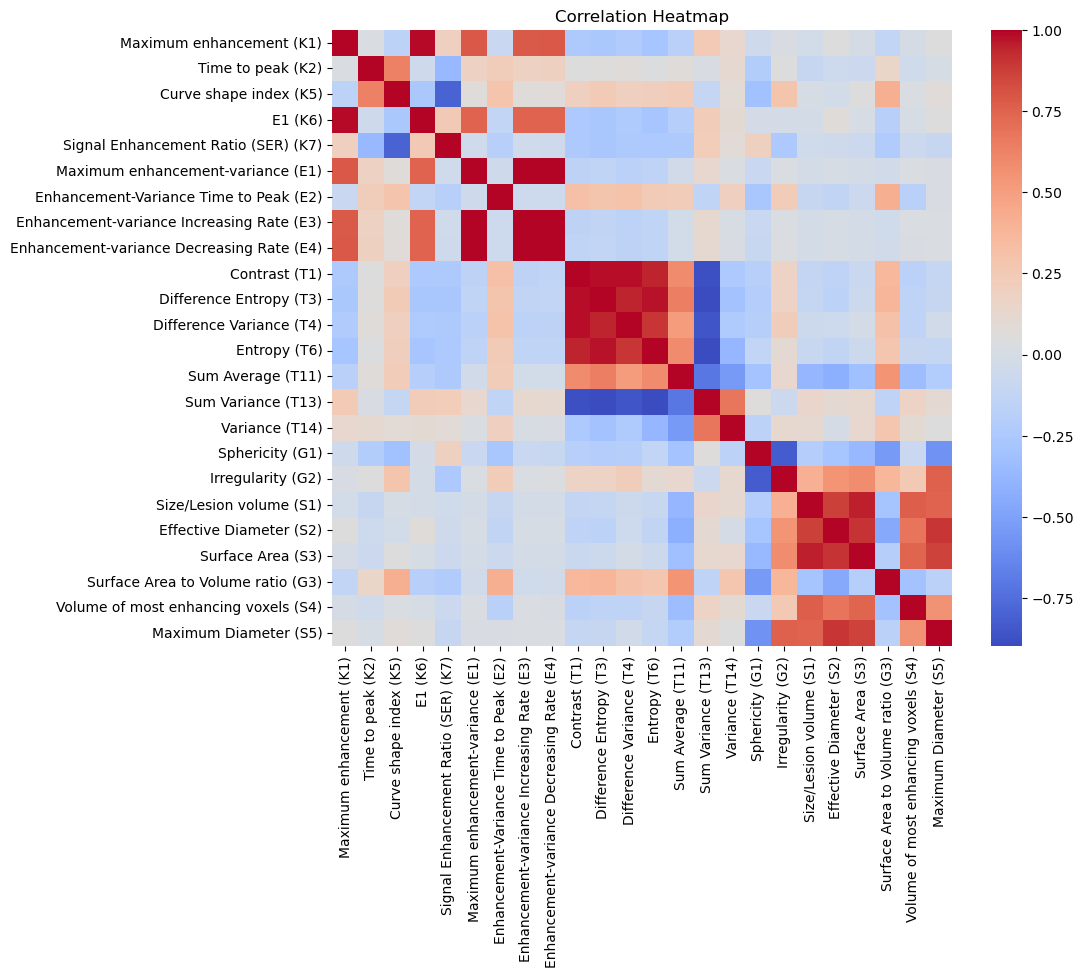

In [10]:
correlation_matrix = df[selected_columns_after_variance].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

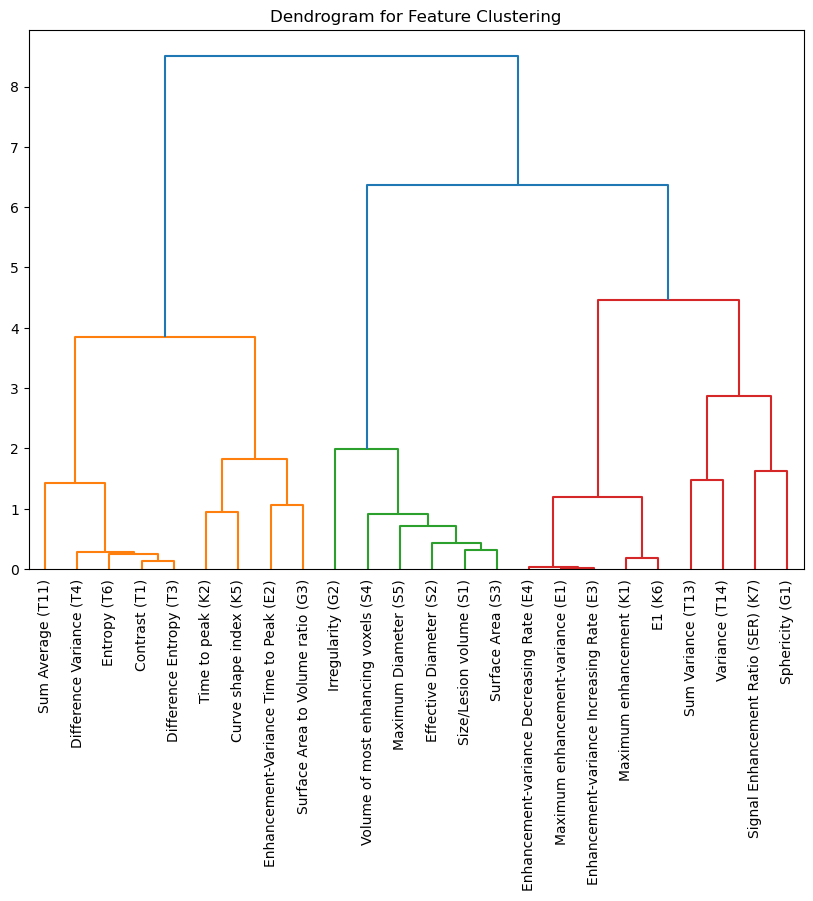

In [11]:
linkage_matrix = linkage(correlation_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=selected_columns_after_variance, leaf_rotation=90)
plt.title("Dendrogram for Feature Clustering")
plt.show()

In [12]:
representative_features = cluster_and_select_representative_features(
    correlation_matrix=correlation_matrix,
    num_clusters=3
)

In [13]:
print(f"Number of representative features: {len(representative_features)}")
print(f"Representative features selected from clusters: {representative_features}")

Number of representative features: 3
Representative features selected from clusters: ['Maximum enhancement-variance (E1)', 'Contrast (T1)', 'Surface Area (S3)']


# Train

In [14]:
def train_and_evaluate_model(df, features, target_col, model, stratify_col='Pam50.Call', imprimir=False):
    X_train, X_test, y_train, y_test = train_test_split(
        df[features],
        df[target_col],
        test_size=0.2,
        random_state=42,
        stratify=df[stratify_col]
    )
        
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    if imprimir:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
    
    return macro_f1

In [15]:
rf_model = RandomForestClassifier(random_state=42)

macro_f1_score = train_and_evaluate_model(
    df=df,
    features=[col for col in df.columns if col != "Pam50.Call"],
    target_col="Pam50.Call",
    model=rf_model,
    imprimir=True
)

Classification Report:
              precision    recall  f1-score   support

       Basal       0.00      0.00      0.00         2
        Her2       0.00      0.00      0.00         1
        LumA       0.69      1.00      0.81        11
        LumB       0.00      0.00      0.00         2

    accuracy                           0.69        16
   macro avg       0.17      0.25      0.20        16
weighted avg       0.47      0.69      0.56        16



C:\Users\Jose\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jose\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jose\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
